# Implementation of solving algorithm

## Section 1: 1-D Case

After including group 4 code we want to analyze the best way to solve the linear problem $Au=b$. Our main concern was to analyze the best solving algorithm and, paired with that, the best way to store the matrix. Using the code provided by group 4 we have also considered to compare the time spent to generate the linear problem and the time spent to solve it. 
<br>Looking forward to solve higher dimension problem we also dived into iterative solvers.

In [1]:
include("group4.jl")
import gmsh 
using GR 

using LinearAlgebra 
using SparseArrays 
using StaticArrays
using StaticRanges
using StructArrays
using FastGaussQuadrature
using IterativeSolvers
using Preconditioners
using LinearSolve
using AlgebraicMultigrid: SmoothedAggregationAMG ,RugeStubenAMG, ruge_stuben,smoothed_aggregation, aspreconditioner

using BenchmarkTools
using Test 

using Plots 
using Profile
using ProfileView
using IncompleteLU

using LinearAlgebra
using SparseArrays 
using StructArrays
using StaticArrays
using StaticRanges
using FastGaussQuadrature
using IterativeSolvers
using Preconditioners
using LinearSolve
using BenchmarkTools
using Profile
using ProfileView
using IncompleteLU
using Plots 

1001-element Vector{Float64}:
 0.0
 1.0009999999998906e-6
 2.0040000000000036e-6
 3.0089999999998936e-6
 4.016000000000007e-6
 5.024999999999897e-6
 6.036000000000011e-6
 7.0489999999999e-6
 8.064000000000013e-6
 9.080999999999903e-6
 ⋮
 0.0019760640000000018
 0.001979049000000002
 0.0019820360000000017
 0.0019850250000000022
 0.0019880160000000017
 0.001991009000000002
 0.0019940040000000015
 0.0019970010000000017
 0.0009999999999998899

In [16]:
function buildMatandVec(dim)
    returning_struct = []
    mesh = genMesh(dim)
    c(x) = x
    S = genStiffMat(mesh,c)
    M = genMassMat(mesh)
    A = S - M
    A[1,1] = 1.
    A[1,2] = 0.
    fsource(x) = x*(x-1)
    f = genVector(mesh,fsource)
    f[1] = 0.
    push!(returning_struct, A);
    push!(returning_struct,f);
    return returning_struct;
end

buildMatandVec (generic function with 1 method)

### 1.1 Algorithm comparation

In this section we compare the time spent by different solving algorithm. For the one dimension problem we have chosen to analyze the classical "\\" operator, with and without using the LU decomposition, and two different iterative solvers: $pcg$ : preconditioned conjugate gradient method using the $ILU$ preconditioner and the $MINRES$ method. <br> The conjugate gradient method starts with a guess for the u vector and stops whetever the $residual: r=\|\mathbf{Au-b}\|$ is as near as we initially wanted to be to $0$. <br> The $MINRES  method$  uses the same idea but it doesn't assume that the matrix is positive definite. 

In [17]:
#function that does the LU decomposition
function LU_pre(m)
    return lu(m)
end
#function that does the LU calculation
function LU_calc(lu, f)
    return lu\f
end
#function that does the backslash calculation
function backslash(m::Tridiagonal{Float64, Vector{Float64}}, f::Vector{Float64})
    return m\f
end
#function that calculates the time to solve the linear problem with different algorithm, it stores the various time in a vector and returns it
function solve_and_write_time(n)
    #the n parameter rapresent the dimension of the problem
    ret = zeros(3);
    
    LP=buildMatandVec(n)
    #Measure the time to solve the linear system with the cg method using a tolerance of 1e-7
    elapsed_time_solving = @elapsed begin
        preconditioner = ilu(LP[1])
        x = cg(LP[1], LP[2], Pl=preconditioner,abstol=1e-7)
    end
    ret[1] = elapsed_time_solving

    #Measure the time to solve the linear system with the MINRES algorithm
    elapsed_time_minres = @elapsed begin
        x=minres(LP[1],LP[2],abstol=1e-4)
    end
    ret[2] = elapsed_time_minres
    
    #Measure the time to solve the linear system with the LU decomposition and \ operator
    
    elapsed_time_LU = @elapsed begin
        LP[1]=Tridiagonal(LP[1])
        luMat = LU_pre(LP[1])
        x = LU_calc(luMat, LP[2])
    end
    ret[3] = elapsed_time_LU

    #returns the vector with the times
    return ret
end

solve_and_write_time (generic function with 1 method)

Now we need to call the function to see how the time changes with the increasing of the dimension of the problem for each algorithm, so we make a loop in which we iterate the dimension and in each iteration we calculate the time to solve the linear problem

In [18]:
# Set the dimensions for the loop (e.g., from 2 to 100000 with a step of 1000)
dimensions = 2:100:10000
times_cg = []
times_LU = []
times_minres = []
# Solve linear systems and collect elapsed times
for n in dimensions
    time = solve_and_write_time(n)
    push!(times_cg, time[1])
    push!(times_minres,time[2])
    push!(times_LU,time[3])
end

# Plot the graph
plot(dimensions, times_cg, xlabel="Dimension", ylabel="Elapsed Time (seconds)", label="Solving_ilupcg", legend=:topleft)
plot!(dimensions,times_LU, label="Solving_LU")
plot!(dimensions,times_minres, label="Solving MINRES")


This is the graphs of time complexity, the tolerance used for the $MINRES$ method is $1e-4$ while the tolerance used for the $pcg$ method is $1e-7$ . <br> So we can see that the $MINRES$ method, even using a greater error, doesn't fit well the problem, so we compare only the preconditioned conjugate gradient method and the $LU$ decomposition method. <br>
Inside the time analysis there is also the conversion from a Sparse matrix that best fits the $pcg$ method, as provided by group 4, to a Tridiagonal one, that best fits the $LU$ decomposition method.

In [ ]:
plot(dimensions, times_cg, xlabel="Dimension", ylabel="Elapsed Time (seconds)", label="Solving_ilupcg", legend=:topleft)
plot!(dimensions,times_LU, label="Solving_LU")

### 1.2 Precision analysis
Considering the fact that we are comparing a direct method that computes the "real" solution to an iterative one that computes an approximative solution we have to consider how similar the solutions are.
So, in this code we plot the three vectors, solutions to a problem that generates a 10000x10000 matrix, computed by the three different methods to see how they differ from each other. <br> We can see that the differencies between the real solution and the $pcg$ one can't be seen, while the minres solution is different as we expected using a larger tolerance.

In [ ]:
LP=buildMatandVec(9999);
#pcg solution 
preconditioner = ilu(LP[1]);
cg_solution = cg(LP[1], LP[2], Pl=preconditioner,abstol=1e-7);
#minres solution
minres_solution = minres(LP[1],LP[2],abstol=1e-4);
#LU solution
LP[1]=Tridiagonal(LP[1])
luMat = LU_pre(LP[1])
lu_solution = LU_calc(luMat, LP[2])

#plotting code

plot(cg_solution)
plot!(minres_solution)
plot!(lu_solution)


Pay attention to the scale, it's visible that the two solution differs only in the 10th decimal cypher

In [ ]:
plot(cg_solution-lu_solution,ylim=(-0.0000000003,+0.0000000003),xlim=(-10000,10000),label="differences between solutions")
x_axis(y)=0;
vline!(y_axis,color="black",label=false)
plot!(x_axis,color="black",label=false)

### 1.3 Comparison between Assemblying time and solving time

We wanted to chose an algorithm that has a solving time as close as possible to the assemblying time, even make it dominant to provide the optimal solution algorithm. So we provide an Analysis of the assemblying time as we did before to see how the time complexity changes with the increasing of the dimension of the problem.

In [ ]:
#function that calculates the time to solve the linear problem with different algorithm, and the assembly time, it stores the various time in a vector and returns it
function solve_and_write_time(n)
    #the n parameter rapresent the dimension of the problem
    ret = zeros(3);
    #Measure the time to assemble the linear problem
    elapsed_time_assembly = @elapsed begin
        LP=buildMatandVec(n)
    end
    ret[1] = elapsed_time_assembly;
    
    #Measure the time to solve the linear system with the cg method using a tolerance of 1e-7
    elapsed_time_solving = @elapsed begin
        preconditioner = ilu(LP[1])
        x = cg(LP[1], LP[2], Pl=preconditioner,abstol=1e-7)
    end
    ret[2] = elapsed_time_solving

    #Measure the time to solve the linear system with the LU decomposition and \ operator
    
    elapsed_time_LU = @elapsed begin
        LP[1]=Tridiagonal(LP[1])
        luMat = LU_pre(LP[1])
        x = LU_calc(luMat, LP[2])
    end
    ret[3] = elapsed_time_LU

    #returns the vector with the times
    return ret
end

We can see that the $pcg$ solving time is lower than the assemblying time even for linear matrixes of $1e6 * 1e6$ dimensions

In [ ]:
dimensions = 2:50000:1000000
times_cg = []
times_LU = []
times_assembly = []
# Solve linear systems and collect elapsed times
for n in dimensions
    time = solve_and_write_time(n)
    push!(times_assembly,time[1])
    push!(times_cg, time[2])
    push!(times_LU,time[3])
end

# Plot the graph
plot(dimensions, times_cg, xlabel="Dimension", ylabel="Elapsed Time (seconds)", label="Solving_pcg", legend=:topleft)
plot!(dimensions,times_LU, label="Solving_LU")
plot!(dimensions,times_assembly, label="Assemblying time")

## Section 2: 2-D Case
Including group 4 code that generates the Stiffness matrix, the Mass matrix and the f vector directly from the mesh we want to see how the alogirthms work with the 2-D case and which algorithm best suits our needs. 

In [2]:
include("group4-2D.jl")

buildMatandVec_2D (generic function with 1 method)

### 2.1 Algorithm comparation
For the 2-D problem we are taking in account more 

In [3]:
function LU_pre(m)
    return lu(m)
end

function LU_calc(lu, f)
    return lu\f
end

LU_calc (generic function with 1 method)

In [4]:
function solve_and_write_time(n)
    
    ret = zeros(7);

    
    #Measure the time of assembly
    LP=buildMatandVec_2D(1/n)
    ret[1]= LP[3]
    
    A = LP[1]
    f = LP[2]    


    #Measure the time to solve the linear system with the cg method
    
    elapsed_time_iLU = @elapsed begin
        preconditioner = ilu(A)
        x = cg(A, f, Pl=preconditioner)
    end

    ret[2] = elapsed_time_iLU

    #Measure the time to solve the linear system with the AMG algorithm
    # smoothed_aggregation

    elpased_time_AMGsa= @elapsed begin
        x= solve(A,f,SmoothedAggregationAMG())
        #ml_sa = smoothed_aggregation(A)
        #p_sa = aspreconditioner(ml_sa)
        #x = cg(A, f, Pl = p_sa)
    end

    ret[3]= elpased_time_AMGsa 

    # ruge_stuben

    elpased_time_AMGrs= @elapsed begin

        x= solve(A,f,RugeStubenAMG())
        #ml_rs = ruge_stuben(A)
        #p_rs = aspreconditioner(ml_rs)
        #x = cg(A, f, Pl = p_rs)
    end

    ret[4]= elpased_time_AMGrs 
    
    #=
    Measure the time to solve the linear system with the MINRES algorithm
    elapsed_time_minres = @elapsed begin
        abstol=1e-14
        x=minres(A,f,maxiter=200,abstol=abstol)
    end
    ret[5] = elapsed_time_minres
    =#

    #Measure the time to solve the linear system with the LU decomposition and \ operator
    #A=Tridiagonal(A)

    
    elapsed_time_LU = @elapsed begin
        luMat = LU_pre(A)     
        x = LU_calc(luMat, f)
    end
    
    ret[6]=elapsed_time_LU

    ret[7] = size(f)[1]

    return ret
end


solve_and_write_time (generic function with 1 method)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0726058s, CPU 0.03125s)
Info    : 3013 nodes 6028 elements
Info    : Writing 'square.msh'...
Info    : Done writing 'square.msh'
Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 3013 nodes
Info    : 6028 elements
Info    : Done reading 'square.msh'
Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 3013 nodes
Info    : 6028 elements
Info    : Done reading 'square.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0s, CPU 0s)
Info    : Meshing 2D...
Info   

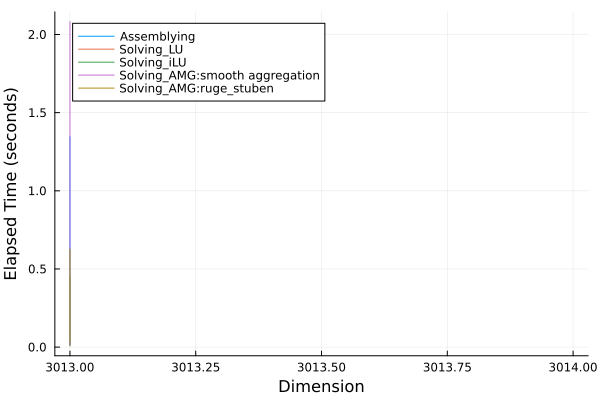

In [5]:

# Set the dimensions for the loop (e.g., from 2 to 100000 with a step of 1000)
dimensions = 2:1:50

times_assembly = []
times_iLU = []
times_LU = []
times_minres=[]
times_AMGsa=[]
times_AMGrs=[]
times_meshProduce=[]
steps = []

#times_minres = []
# Solve linear systems and collect elapsed times
for n in dimensions
    time = solve_and_write_time(n)

    push!(steps, time[7])
    
    push!(times_assembly, time[1])
    

    push!(times_iLU, time[2])
    push!(times_minres,time[5])

    push!(times_LU,time[6])
    
    push!(times_AMGsa,time[3])
    push!(times_AMGrs,time[4])
    
end

# Plot the graph
Plots.plot(steps, times_assembly, xlabel="Dimension", ylabel="Elapsed Time (seconds)", label="Assemblying", legend=:topleft)
#Plots.plot!(steps, times_meshProduce, label="meshProduce")
Plots.plot!(steps,times_LU, label="Solving_LU")
Plots.plot!(steps,times_iLU, label="Solving_iLU")
#plots.plot!(dimensions,times_minres, label="Solving MINRES")
Plots.plot!(steps,times_AMGsa, label="Solving_AMG:smooth aggregation")
Plots.plot!(steps,times_AMGrs, label="Solving_AMG:ruge_stuben")